In [1]:
import xgboost as xgb
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import joblib
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from keras.metrics import RootMeanSquaredError
from keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

In [2]:
def createdf(number):
    nombres_columnas = ['unit', 'cycle', 'op_setting_1', 'op_setting_2', 'op_setting_3']
    nombres_columnas += [f'sensor_{i}' for i in range(1, 24)]
    df = pd.read_csv(rf"./CMAPSSData/train_FD00{number}.txt",sep = " ", header = None, index_col = None)
    df.columns = nombres_columnas
    df = df.iloc[:, :-2]
    return df

In [3]:
df = createdf(4)
max_cycle_by_unit = df.groupby('unit')['cycle'].transform('max')
df['RUL'] = max_cycle_by_unit - df['cycle']

In [4]:
X_total = df.drop(['unit', 'cycle', 'RUL'], axis = 1)
y = df.RUL
X_final = pd.read_csv('X_final.csv')
X_scaled = pd.read_csv('X_scaled.csv')

In [5]:
X_final

,sensor_14,sensor_11,sensor_16,sensor_4,sensor_17,sensor_3,sensor_9,pca_1,pca_2,pca_3
0,0.081921,-0.365205,-0.694278,-0.745729,-0.638665,-0.701412,-0.633237,-2.767201,1.957162,-0.179409
1,-0.253086,0.328498,-0.694278,0.298212,0.476120,0.562449,0.560738,1.372082,0.524494,1.114870
2,-0.013912,-0.374454,-0.694278,-0.711202,-0.674626,-0.704332,-0.646979,-2.794790,1.934897,-0.156155
3,0.096162,-0.368288,-0.694278,-0.702990,-0.710586,-0.722040,-0.630180,-2.752903,1.957141,-0.228195
4,-2.358027,-1.971512,-0.694278,-1.410627,-1.537685,-1.532181,-1.572260,-4.313926,-4.192801,0.018765
...,...,...,...,...,...,...,...,...,...,...
61244,1.375959,0.988286,1.440345,0.950036,0.871689,0.927441,0.936371,3.208030,0.008634,-0.741897
61245,1.373391,1.592578,1.440345,1.884363,1.734748,1.705086,1.758394,6.290364,-1.069837,-0.172601
61246,1.472259,1.654240,1.440345,1.916124,1.698787,1.787974,1.786324,6.303729,-1.090019,-0.156480
61247,0.675012,-0.106223,-0.694278,-0.450322,-0.386939,-0.344803,-0.359229,-1.644335,1.609925,-0.153859


In [6]:
X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(X_final, y, test_size=0.2, random_state=42)
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [7]:
def modelo_XGBoost(X_train,X_test, y_train, y_test, model_name):
    params = {
    'objective': 'reg:squarederror',
    'eval_metric': ['rmse'],
    'max_depth': 7,
    'learning_rate': 0.01,
    #'subsample': 0.8,
    #'colsample_bytree': 0.9,
    'n_estimators': 1000,
}

    modelo = xgb.XGBRegressor(**params)

    modelo.fit(X_train, y_train, eval_set = [(X_test, y_test)], verbose = 0)

    y_pred = modelo.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R² Score: {r2:.4f}")

    
    joblib.dump(modelo, f'final_models/xgb_model_{model_name}.pkl')

    

In [8]:
%%time
modelo_XGBoost(X_train_final, X_test_final, y_train_final, y_test_final, 'final')

RMSE: 58.5543
MAE: 42.3422
R² Score: 0.5736
CPU times: total: 43.1 s
Wall time: 2.81 s


In [9]:
%%time
modelo_XGBoost(X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, 'scaled')

RMSE: 55.1728
MAE: 39.7534
R² Score: 0.6214
CPU times: total: 59.1 s
Wall time: 3.82 s


In [10]:
def modelo_random_Forest(X_train,X_test, y_train, y_test, model_name):

    modelo = RandomForestRegressor(max_depth=15, min_samples_split=8, n_estimators=750)

    modelo.fit(X_train, y_train)

    y_pred = modelo.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R² Score: {r2:.4f}")

    
    joblib.dump(modelo, f'final_models/RFR_model_{model_name}.pkl')


In [11]:
%%time
modelo_random_Forest(X_train_final, X_test_final, y_train_final, y_test_final, 'final')

RMSE: 58.5209
MAE: 42.3200
R² Score: 0.5741
CPU times: total: 3min 30s
Wall time: 3min 34s


In [12]:
%%time
modelo_random_Forest(X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, 'scaled')

RMSE: 55.3535
MAE: 39.9137
R² Score: 0.6189
CPU times: total: 5min 41s
Wall time: 5min 50s


In [13]:
def LSTM_secuencia(df, df_valores ,ventana=30):
    max_cycle_by_unit = df.groupby('unit')['cycle'].transform('max')
    df['RUL'] = max_cycle_by_unit - df['cycle']
    sequencias = []
    etiquetas = []
    df_no_escaladas = df[['unit','cycle', 'RUL']]
    df_combinado = pd.concat([df_no_escaladas, df_valores], axis= 1)
    for motor, grupo in df_combinado.groupby('unit'):
        grupo = grupo.sort_values('cycle')
        valores = grupo[df_valores.columns].values
        rul_valores = grupo.RUL.values
        for i in range(len(grupo) - ventana + 1):
            X_ventana = valores[i:i+ventana]
            y_ventana = rul_valores[i+ventana - 1]
            sequencias.append(X_ventana)
            etiquetas.append(y_ventana)
    return np.array(sequencias), np.array(etiquetas)

In [14]:
def modelo_LSTM(df, df_valores, model_name, ventana):
    X_seq, y_seq = LSTM_secuencia(df, df_valores, ventana=ventana)
    X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)
    n_columnas = X_seq.shape[2]
    model = Sequential()
    model.add(Bidirectional(LSTM(
        units = 64,
        return_sequences=True,
        input_shape=(ventana, n_columnas)
    )))
    model.add(Dropout(0.2))
    model.add(LSTM(
        units= 64,
        return_sequences=False,
    ))
    model.add(Dense(1))
    model.compile(
        optimizer='adam',
        loss='mse',
        metrics = [RootMeanSquaredError(name='rmse')]
    )

    early_stop = EarlyStopping(monitor='val_rmse', patience=3, restore_best_weights=True, mode='min')

    history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2,callbacks=[early_stop])

    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    model.save(f"final_models/best_lstm_model_{model_name}_kt.h5")

    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R² Score: {r2:.4f}")
    print(model.summary())

    plt.figure(figsize=(12, 5))
    plt.plot(history.history['loss'], label='Entrenamiento')
    plt.plot(history.history['val_loss'], label='Validación')
    plt.title(f'Pérdida del modelo best_lstm_model_{model_name}')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'Pérdida  del modelo best_lstm_model_{model_name}')
    plt.show()

    plt.figure(figsize=(12, 5))
    plt.plot(history.history['rmse'], label='Entrenamiento - RMSE')
    plt.plot(history.history['val_rmse'], label='Validación - RMSE')
    plt.title(f'RMSE del modelo best_lstm_model_{model_name}')
    plt.xlabel('Épocas')
    plt.ylabel('RMSE')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'rmse_best_lstm_model_{model_name}.png')
    plt.show()

Epoch 1/50


C:\Users\Borja\anaconda3\envs\tfm\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1031/1031 ━━━━━━━━━━━━━━━━━━━━ 23s 19ms/step - loss: 15574.5332 - rmse: 124.5638 - val_loss: 9229.1328 - val_rmse: 96.0684
Epoch 2/50
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - loss: 8285.6162 - rmse: 90.9971 - val_loss: 6975.0703 - val_rmse: 83.5169
Epoch 3/50
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - loss: 6744.0093 - rmse: 82.1123 - val_loss: 6726.4453 - val_rmse: 82.0149
Epoch 4/50
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - loss: 6692.6270 - rmse: 81.8057 - val_loss: 6719.8604 - val_rmse: 81.9748
Epoch 5/50
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step - loss: 6720.3628 - rmse: 81.9746 - val_loss: 6720.0894 - val_rmse: 81.9762
Epoch 6/50
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step - loss: 6630.5811 - rmse: 81.4272 - val_loss: 6719.7183 - val_rmse: 81.9739
Epoch 7/50
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - loss: 6667.4922 - rmse: 81.6507 - val_loss: 5328.4912 - val_rmse: 72.9965
Epoch 8/50
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - loss: 4345.5425 - rmse: 65.

RMSE: 13.0675
MAE: 7.3841
R² Score: 0.9740


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 40, 128)        │        38,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 40, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 263,621 (1.01 MB)

 Trainable params: 87,873 (343.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 175,748 (686.52 KB)

None


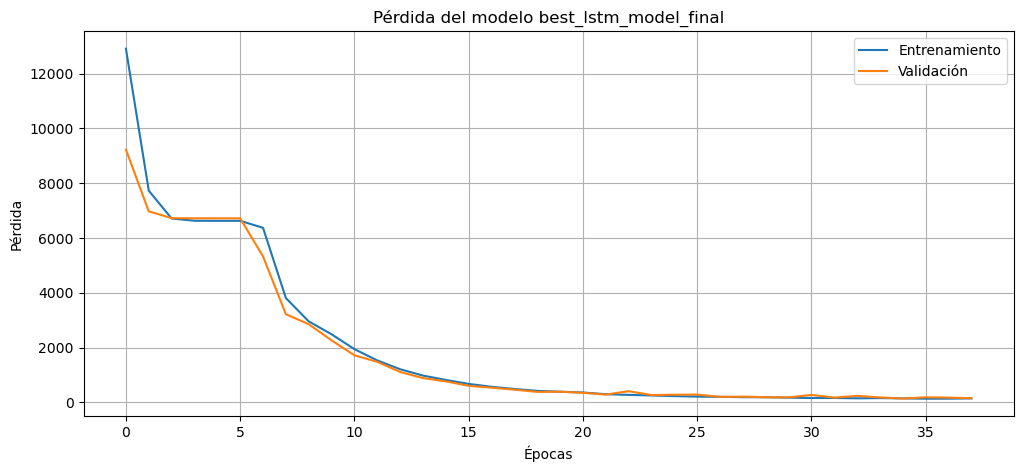

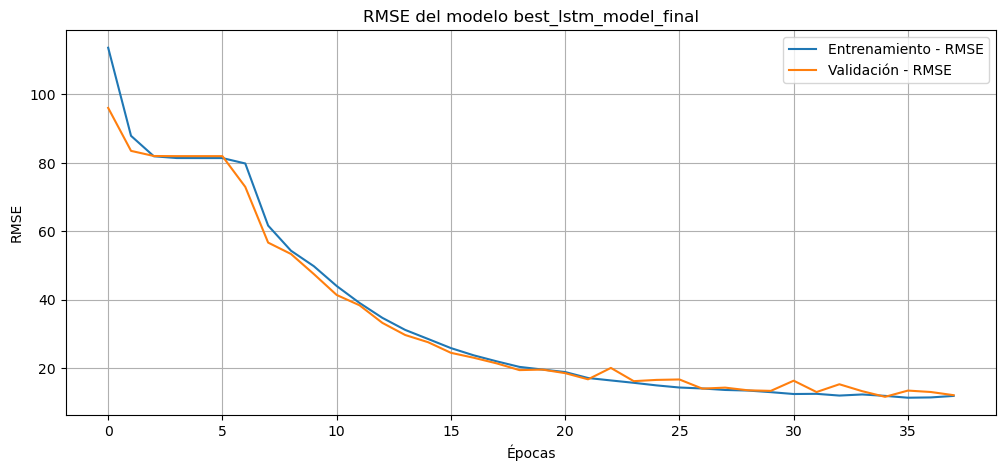

CPU times: total: 1h 14s
Wall time: 12min 17s


In [15]:
%%time
modelo_LSTM(df, X_final, 'final', 40)

Epoch 1/50


C:\Users\Borja\anaconda3\envs\tfm\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1031/1031 ━━━━━━━━━━━━━━━━━━━━ 24s 21ms/step - loss: 15231.3721 - rmse: 123.1601 - val_loss: 9061.9053 - val_rmse: 95.1940
Epoch 2/50
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 22s 21ms/step - loss: 8168.8237 - rmse: 90.3537 - val_loss: 6935.5947 - val_rmse: 83.2802
Epoch 3/50
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 20s 20ms/step - loss: 6700.4624 - rmse: 81.8506 - val_loss: 6723.4858 - val_rmse: 81.9969
Epoch 4/50
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 20s 20ms/step - loss: 6634.2178 - rmse: 81.4485 - val_loss: 6719.3267 - val_rmse: 81.9715
Epoch 5/50
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 21s 20ms/step - loss: 6625.8677 - rmse: 81.3924 - val_loss: 6719.2837 - val_rmse: 81.9712
Epoch 6/50
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 21s 20ms/step - loss: 6781.4233 - rmse: 82.3413 - val_loss: 6719.3281 - val_rmse: 81.9715
Epoch 7/50
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 21s 20ms/step - loss: 6179.5952 - rmse: 78.5573 - val_loss: 4098.7725 - val_rmse: 64.0217
Epoch 8/50
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 21s 21ms/step - loss: 3669.4614 - rmse: 60.

RMSE: 12.5264
MAE: 7.7602
R² Score: 0.9761


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_1 (Bidirectional) │ (None, 40, 128)        │        45,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 40, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 285,125 (1.09 MB)

 Trainable params: 95,041 (371.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 190,084 (742.52 KB)

None


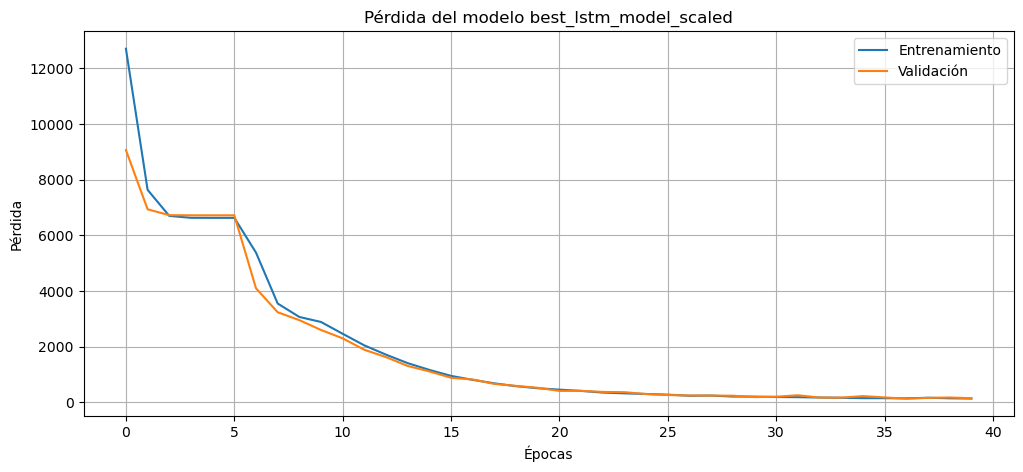

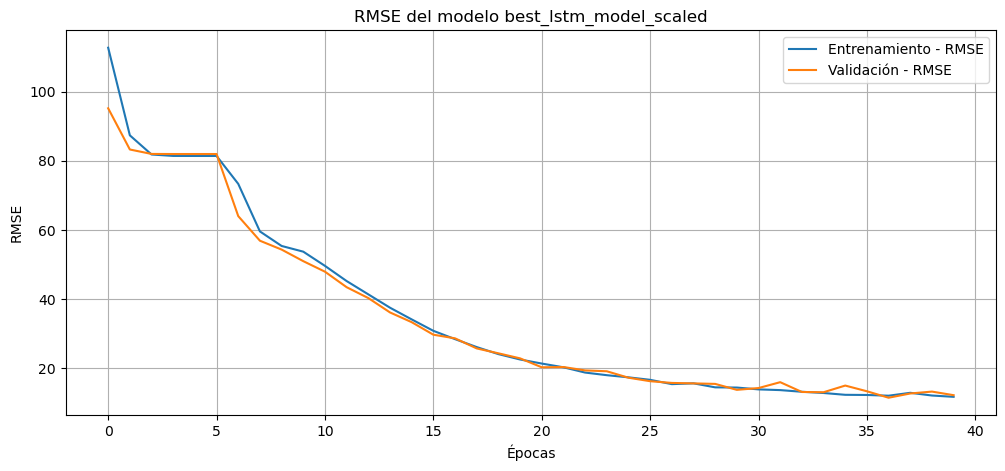

CPU times: total: 1h 6min 39s
Wall time: 13min 34s


In [16]:
%%time
modelo_LSTM(df, X_scaled, 'scaled', 40)